In [1]:
'''
Train/test split 75/25
~50 iterations

Document:
What you’re trying to do
What you expect
parameters/code/etc.
What you received
Any relevant output figures



the "Outcome" column in the dataframe is the 0s and 1s and indicates whether the node is in the SOZ or not. these will be the "y" values in the model

get_df_list gets you a list of all the dataframes for positive patients. use this to run your analysis on each dataframe

concat_dfs gets you one big dataframe for all positive patients. run analysis on this as well.

base_path = a local location to a folder, in which you have stored all the downloaded patient folders from Mark's onedrive link. 

Important notes here: 
For patients PY18N013 and PY19N011, you need to go into the ResponseInfo folder and make a folder called CCEP and put the response files inside.
Also remember not to train on "flipped" and "significant" columns


'''

'\nTrain/test split 75/25\n~50 iterations\n\nDocument:\nWhat you’re trying to do\nWhat you expect\nparameters/code/etc.\nWhat you received\nAny relevant output figures\n\n\n\nthe "Outcome" column in the dataframe is the 0s and 1s and indicates whether the node is in the SOZ or not. these will be the "y" values in the model\n\nget_df_list gets you a list of all the dataframes for positive patients. use this to run your analysis on each dataframe\n\nconcat_dfs gets you one big dataframe for all positive patients. run analysis on this as well.\n\nbase_path = a local location to a folder, in which you have stored all the downloaded patient folders from Mark\'s onedrive link. \n\nImportant notes here: \nFor patients PY18N013 and PY19N011, you need to go into the ResponseInfo folder and make a folder called CCEP and put the response files inside.\nAlso remember not to train on "flipped" and "significant" columns\n\n\n'

In [7]:
import json
import glob
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs

In [14]:
#Location
base_path = '/Users/samanthatam/Documents/year4/PCM/data/' #modify for your file location

#Function to get a list of all dataframes for all positive patients, in the format [patient number, df]
df_list = get_df_list(base_path, "1")
    
#Function to get the concatenated dataframe for all positive patients
all_positive_patients = concat_dfs(base_path, "1")

#drop significant and flipped columns
for i in range(len(df_list)):
    df_list[i][1].drop(columns=['chNames', 'flipped', 'significant'], inplace=True)
all_positive_patients.drop(columns=['chNames','flipped', 'significant'], inplace=True)

/Users/samanthatam/epilepsypcm/epilepsypcm/utils/make_df.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outcome"][df["chNames"] == channel] = 1


In [4]:
df_list

[['PY21N008',
          chNames  significant  n1Zscore  n2Zscore  p2Zscore  n1Latency  \
  2       LA3_LA4          0.0  1.396644  1.062212 -5.025081       13.0   
  6       LA7_LA8          0.0  1.371992  1.735958 -0.305671       17.0   
  7       LA8_LA9          0.0  1.990935  0.596185  0.596185       19.0   
  10    LAH2_LAH3          0.0  4.324042  4.524443 -1.176967       16.0   
  11    LAH3_LAH4          0.0  4.214433  2.351241 -1.154445       15.0   
  ...         ...          ...       ...       ...       ...        ...   
  2815  RAH4_RAH5          0.0 -4.623911  0.930344  4.126570       11.0   
  2816  RAH5_RAH6          0.0 -0.006959 -3.854115 -0.006959       51.0   
  2817  RAH6_RAH7          0.0 -3.899049  0.688887  0.688887       11.0   
  2818  RAH7_RAH8          0.0  2.489016  1.919793  0.472198       13.0   
  2819  RAH8_RAH9          0.0  2.600048  3.240657  1.017700       11.0   
  
        n2Latency  p2Latency  flipped  outcome  
  2         180.0       43.0      

In [5]:
all_positive_patients

,chNames,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,outcome
2,LA3_LA4,1.396644,1.062212,-5.025081,13.0,180.0,43.0,1.0
6,LA7_LA8,1.371992,1.735958,-0.305671,17.0,131.0,47.0,0.0
7,LA8_LA9,1.990935,0.596185,0.596185,19.0,101.0,101.0,0.0
10,LAH2_LAH3,4.324042,4.524443,-1.176967,16.0,101.0,45.0,1.0
11,LAH3_LAH4,4.214433,2.351241,-1.154445,15.0,110.0,43.0,1.0
...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,-0.775927,-2.579947,4.290270,51.0,285.0,195.0,0.0
707,RPFS7_RPFS8,1.769931,5.228859,-3.093837,12.0,139.0,69.0,0.0
708,RPFI1_RPFI2,1.361718,2.097774,-1.999799,14.0,338.0,278.0,0.0
709,RPFI2_RPFI3,-2.863802,-2.631576,7.996893,44.0,228.0,118.0,0.0


<ipython-input-25-b61a92034a16>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

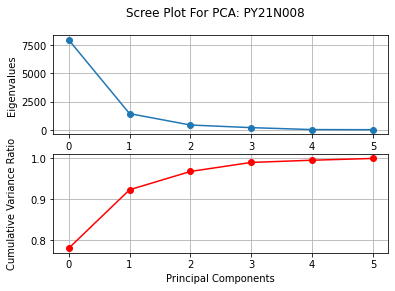

<Figure size 432x288 with 0 Axes>

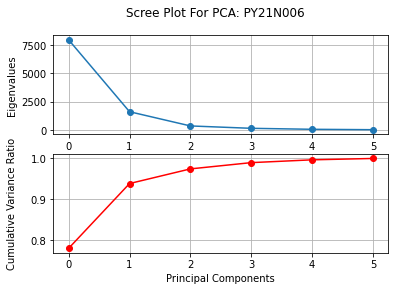

<Figure size 432x288 with 0 Axes>

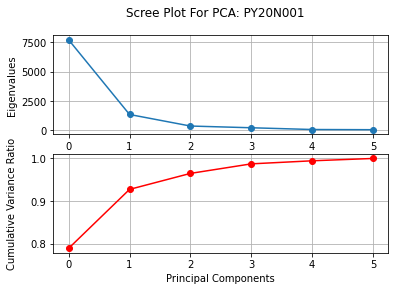

<Figure size 432x288 with 0 Axes>

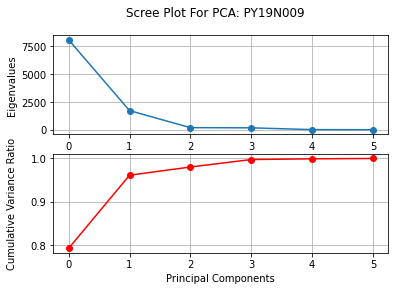

<Figure size 432x288 with 0 Axes>

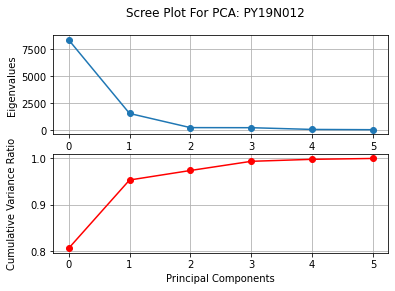

<Figure size 432x288 with 0 Axes>

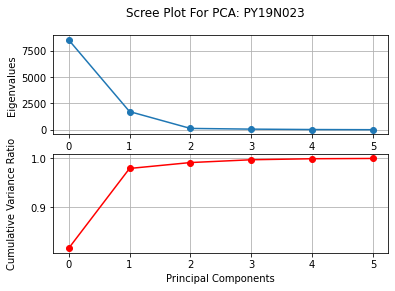

<Figure size 432x288 with 0 Axes>

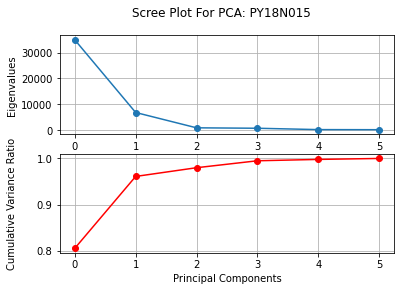

<Figure size 432x288 with 0 Axes>

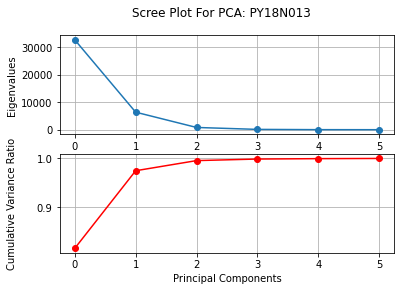

<Figure size 432x288 with 0 Axes>

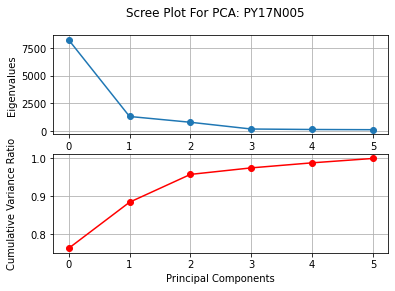

<Figure size 432x288 with 0 Axes>

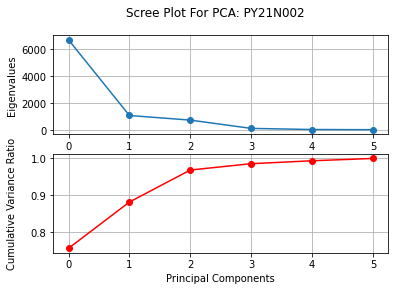

<Figure size 432x288 with 0 Axes>

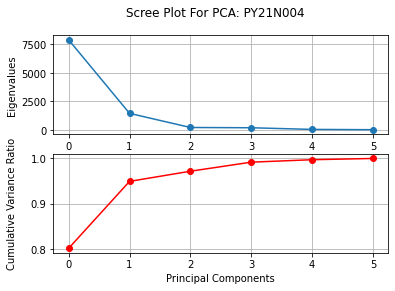

<Figure size 432x288 with 0 Axes>

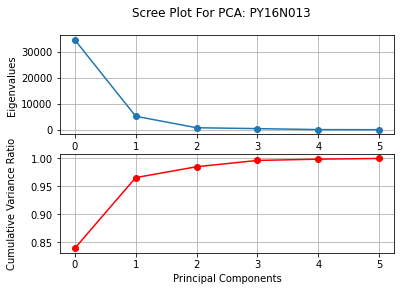

<Figure size 432x288 with 0 Axes>

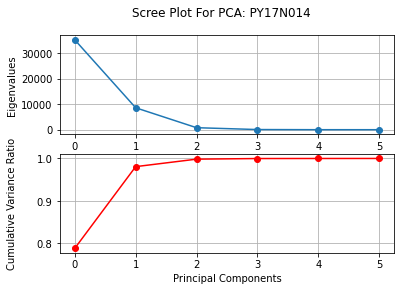

<Figure size 432x288 with 0 Axes>

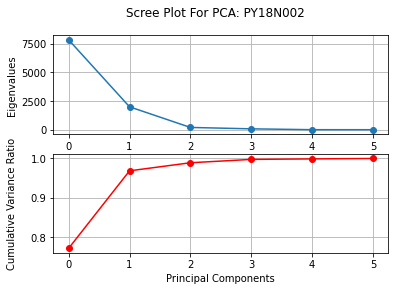

<Figure size 432x288 with 0 Axes>

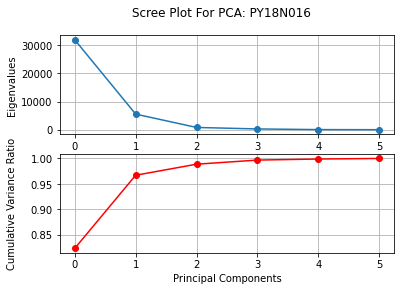

<Figure size 432x288 with 0 Axes>

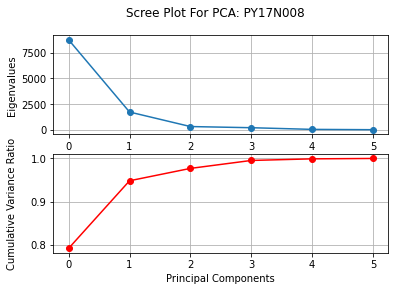

<Figure size 432x288 with 0 Axes>

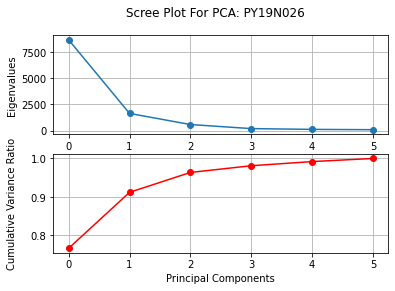

<Figure size 432x288 with 0 Axes>

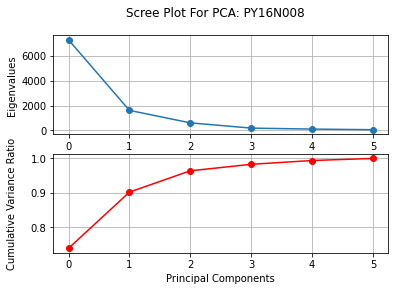

In [25]:
for i in range(len(df_list)):
    #df_list[i][1].drop(columns=['flipped', 'significant'], inplace=True)
    X = df_list[i][1].drop(columns=['outcome'])
    #y = df_list[i][1]['outcome']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pca = PCA(n_components=6)
    pca.fit_transform(X)
    L = pca.explained_variance_ 
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.align_ylabels()
    fig.suptitle('Scree Plot For PCA: %s' % df_list[i][0])

    ax1.plot(L,'o-')
    ax1.set_ylabel('Eigenvalues')
    ax1.grid()

    cmsm = np.cumsum(L)
    ax2.plot(cmsm/cmsm[-1],'o-r')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Cumulative Variance Ratio');
    ax2.grid()
    


<Figure size 432x288 with 0 Axes>

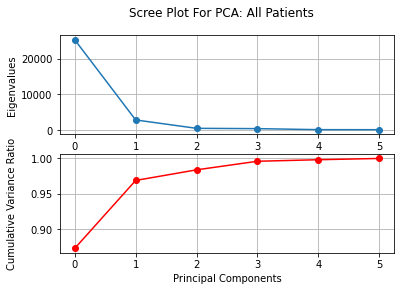

In [26]:
X = all_positive_patients.drop(columns=['outcome'])
#y = all_positive_patients['outcome']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
pca = PCA(n_components=6)
pca.fit_transform(X)
L = pca.explained_variance_ 

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.align_ylabels()
fig.suptitle('Scree Plot For PCA: All Patients')

ax1.plot(L,'o-')
ax1.set_ylabel('Eigenvalues')
ax1.grid()

cmsm = np.cumsum(L)
ax2.plot(cmsm/cmsm[-1],'o-r')
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Cumulative Variance Ratio');
ax2.grid()

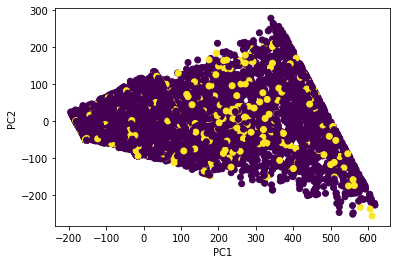

In [20]:
pca = PCA(n_components=2)
new = pca.fit_transform(X)
plt.scatter(new[:,0], new[:,1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()